In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score
from string import punctuation

In [2]:
punctuation_symbols = []
for each in list(punctuation):
    punctuation_symbols.append((each, ''))

In [3]:
def remove_puncuation(x):
    for each in punctuation_symbols:
        x = x.replace(*each)
    return x

In [4]:
nlp = spacy.load('en')

file_names = open('PoemList.txt', 'r')
file_names = file_names.readlines()
file_names = [file[:-1] for file in file_names]
author_poem = [file[:-4] for file in file_names]
poem_titles = [re.sub(r'.*_', '', article) for article in author_poem]
poets = [re.sub(r'_.*', '', article) for article in author_poem]

poems = []
word_count = []
line_count = []
num_of_sents = []
processed_poems = []
max_sent_length = []
min_sent_length = []
for text in file_names:
    opened = open(text, 'r').read()
    poem = opened.replace("\n"," ")
    poem = poem.replace('-', '')
    poems.append(poem)
    
    wordcount = Counter(poem.split())
    wordcount = sum(wordcount.values())
    word_count.append(wordcount)
    
    num_lines = sum(1 for line in open(text))
    line_count.append(num_lines)
    
    sentences = nlp(poem)
    processed_poems.append(sentences)
    
    sentences = [[sent] for sent in sentences.sents]
    num_of_sents.append(len(sentences))
    
    sentence_length = [len(sent[0]) for sent in sentences]
    max_sent_length.append(max(sentence_length))
    min_sent_length.append(min(sentence_length))
    
poems_df = pd.DataFrame()
poems_df['poem'] = poems
poems_df["poem_titles"] = poem_titles
poems_df['authors'] = poets
poems_df['word_count'] = word_count
poems_df['line_count'] = line_count
poems_df['num_of_sents'] = num_of_sents
poems_df['processed_poems'] = processed_poems
poems_df['max_sent_length'] = max_sent_length
poems_df['min_sent_length'] = min_sent_length

poems_df.head()

,poem,poem_titles,authors,word_count,line_count,num_of_sents,processed_poems,max_sent_length,min_sent_length
0,"Lying, thinking Last night How to find my soul...",Alone,Angelou,162,42,16,"(Lying, ,, thinking, Last, night, How, to, fin...",33,3
1,Curtains forcing their will against the win...,AwakingInNewYork,Angelou,38,11,2,"(Curtains, forcing, their, will, , against,...",37,20
2,A free bird leaps on the back of the wind ...,CagedBird,Angelou,193,43,6,"(A, free, bird, leaps, , on, the, back, of, t...",41,37
3,"The eye follows, the land Slips upward, creas...",CaliforniaProdigal,Angelou,130,35,11,"(The, eye, follows, ,, the, land, , Slips, up...",31,6
4,"One foot down, then hop! It's hot. Good things...",HarlemHopscotch,Angelou,90,17,14,"(One, foot, down, ,, then, hop, !, It, 's, hot...",18,4


In [5]:
poems_df = poems_df.sample(frac=1)
poems_df = poems_df.sample(frac=1)
poems_df = poems_df.sample(frac=1)
poems_df = poems_df.sample(frac=1)
poems_df = poems_df.sample(frac=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fc37710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119511278>]], dtype=object)

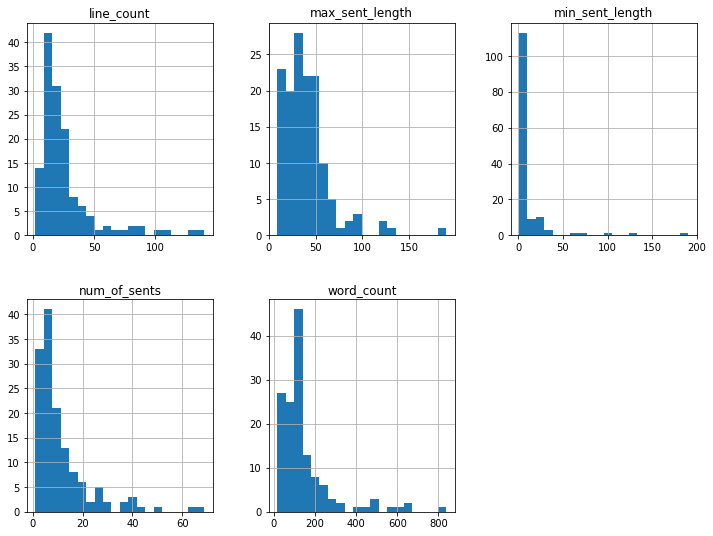

In [6]:
poems_df.hist(bins=20, figsize=(12,9), layout=(2,3))

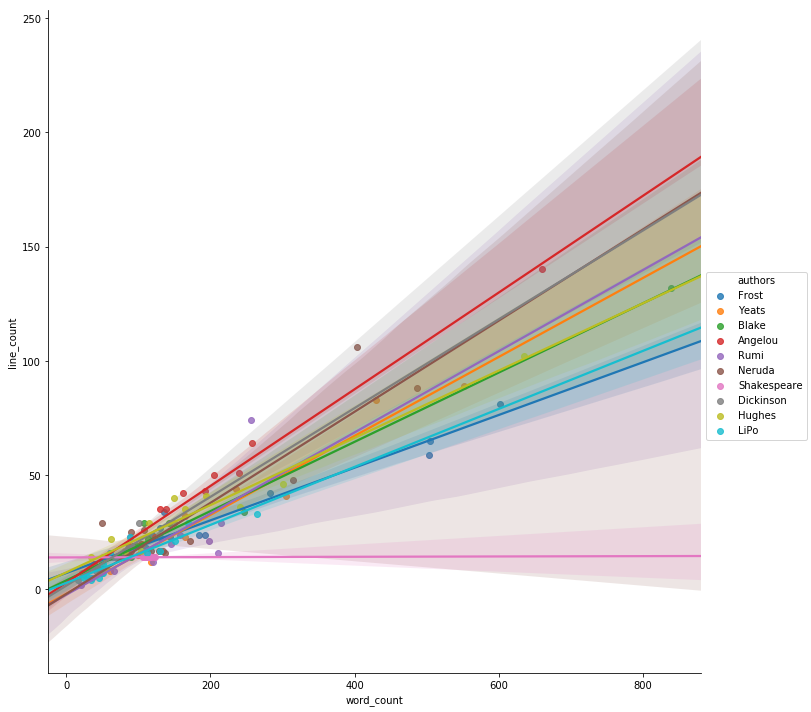

In [7]:
sns.lmplot(x="word_count", y="line_count", hue="authors", size=10, data=poems_df)
plt.show()

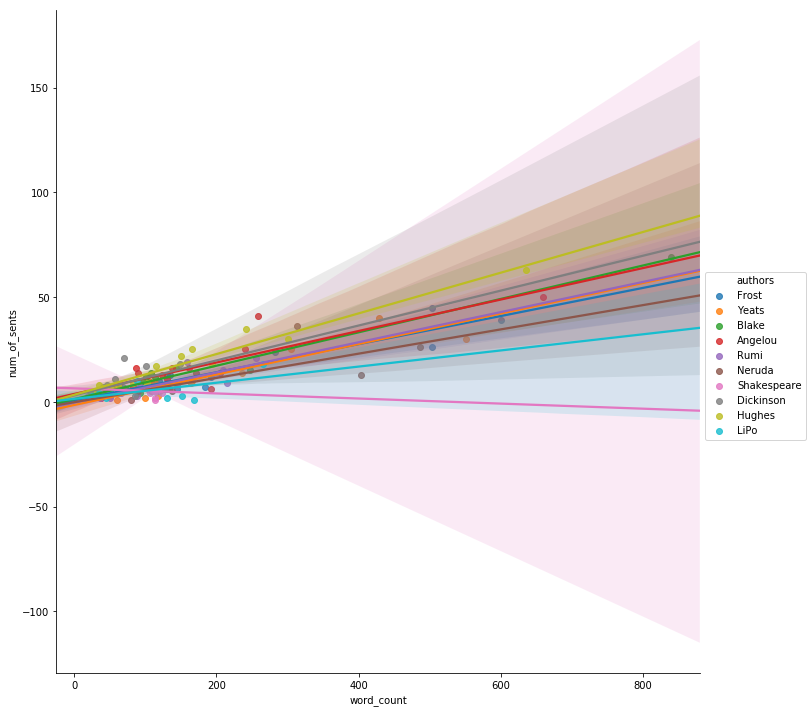

In [8]:
sns.lmplot(x="word_count", y="num_of_sents", hue="authors", size = 10, data=poems_df)
plt.show()

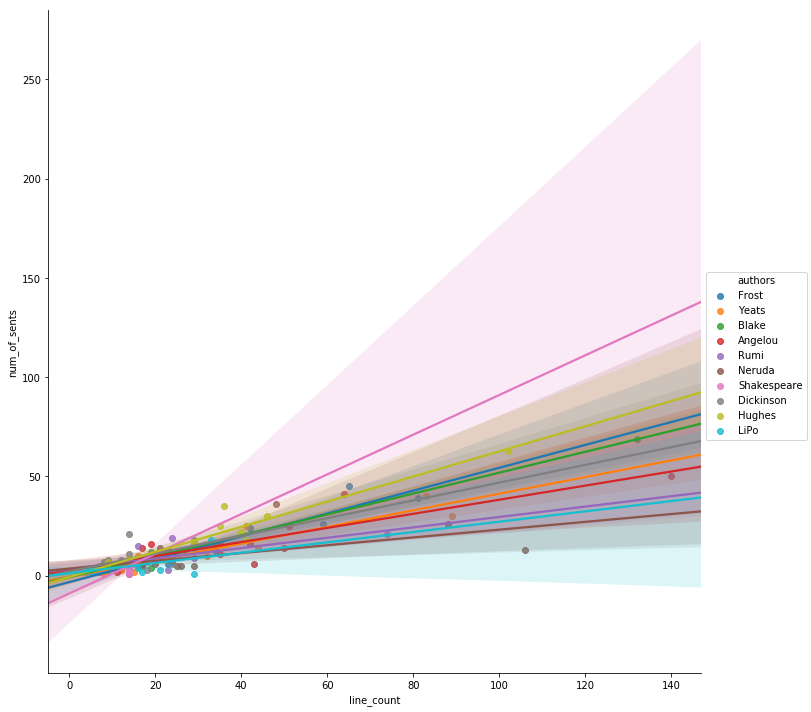

In [9]:
sns.lmplot(x="line_count", y="num_of_sents", hue="authors", size= 10, data=poems_df)
plt.show()

### Do cluster with original non-pca'd features... also use the percentage of variance retained function to see how much variance was kept using pca...

In [10]:
poems_df.columns

Index(['poem', 'poem_titles', 'authors', 'word_count', 'line_count',
       'num_of_sents', 'processed_poems', 'max_sent_length',
       'min_sent_length'],
      dtype='object')

                 word_count  line_count  num_of_sents  max_sent_length  \
word_count         1.000000    0.929991      0.871325         0.270428   
line_count         0.929991    1.000000      0.851084         0.204605   
num_of_sents       0.871325    0.851084      1.000000        -0.042127   
max_sent_length    0.270428    0.204605     -0.042127         1.000000   
min_sent_length   -0.091425   -0.120234     -0.270150         0.670184   

                 min_sent_length  
word_count             -0.091425  
line_count             -0.120234  
num_of_sents           -0.270150  
max_sent_length         0.670184  
min_sent_length         1.000000  


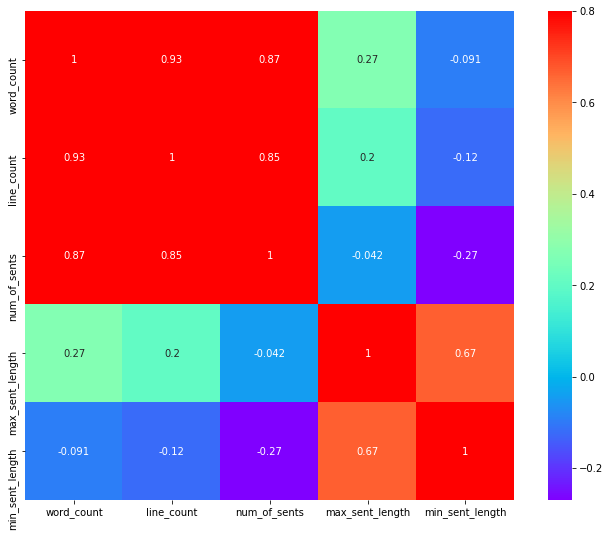

In [11]:
X = poems_df.drop(['poem_titles', 'authors','poem','processed_poems'], axis = 1)

# Make the correlation matrix.
corrmat = X.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, cmap = 'rainbow')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


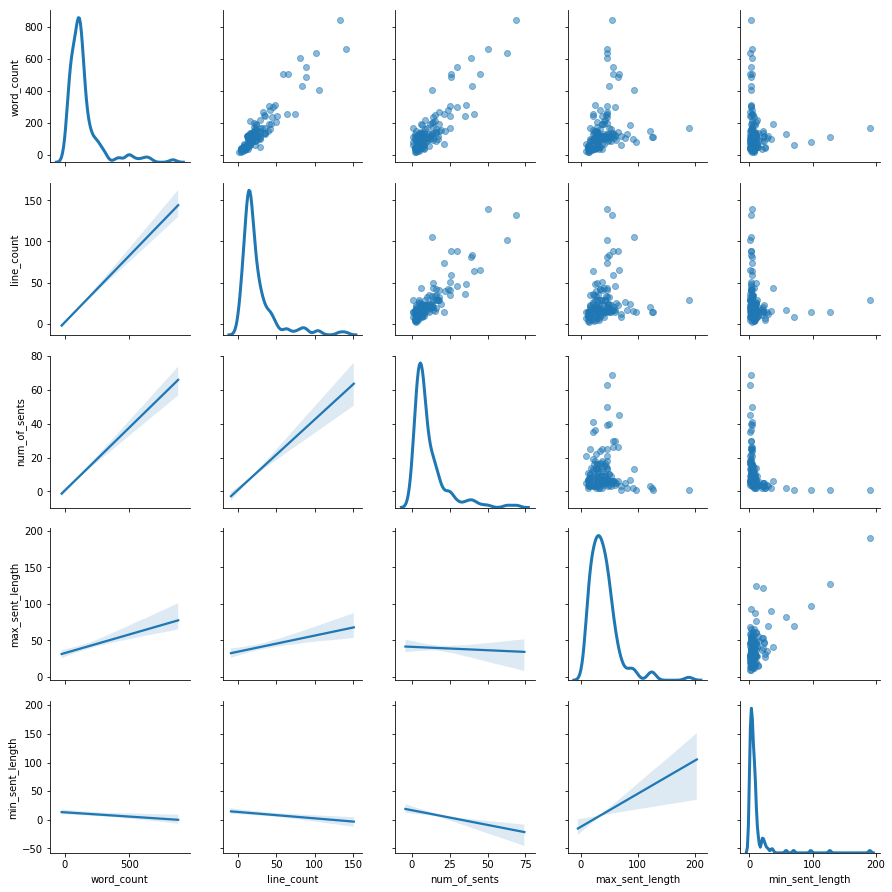

In [12]:
# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(X.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

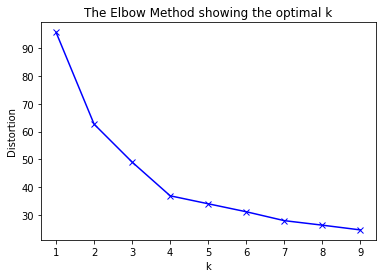

In [13]:
# clustering dataset
# determine k using elbow method
 
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
 
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [14]:
X = poems_df.drop(['poem_titles', 'authors','poem','processed_poems'], axis = 1)

X_norm = normalize(X)

# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_norm)

In [15]:
X = poems_df.drop(['poem_titles', 'authors','poem','processed_poems'], axis = 1)

X_norm = normalize(X)

pca = PCA(n_components = None)
# Reduce it to two components.
X_pca = pca.fit_transform(X_norm)

explained_variance = pca.explained_variance_ratio_

explained_variance

array([ 0.75910363,  0.14165632,  0.06798213,  0.01894819,  0.01230973])

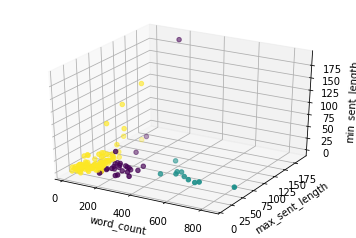

In [16]:
X = poems_df[['word_count', 'max_sent_length','min_sent_length']]

# # Normalize the data.
# X_norm = normalize(X)


# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X['word_count'], X['max_sent_length'], X['min_sent_length'], c=y_pred)

ax.set_xlabel('word_count')
ax.set_ylabel('max_sent_length')
ax.set_zlabel('min_sent_length')

plt.show()

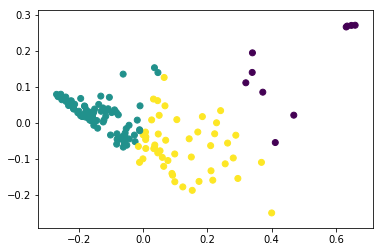

In [17]:
X = poems_df.drop(['poem_titles', 'authors','poem','processed_poems'], axis = 1)

# Normalize the data.
X_norm = normalize(X)

pca = PCA(n_components = 3)

# Reduce it to two components.
X_pca = pca.fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

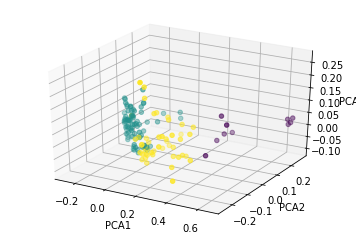

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:,2], c=y_pred)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.show()

In [19]:
cluster_df = poems_df.copy()
cluster_df['cluster'] = y_pred

In [20]:
for i in range(cluster_df['cluster'].nunique()):
    cluster = cluster_df[cluster_df['cluster']== i]
    print('Cluster ', i, '\n', Counter(list(cluster['authors'])),'\n')

Cluster  0 
 Counter({'LiPo': 3, 'Yeats': 2, 'Angelou': 1, 'Neruda': 1, 'Shakespeare': 1, 'Rumi': 1, 'Dickinson': 1}) 

Cluster  1 
 Counter({'Angelou': 13, 'Hughes': 12, 'Frost': 10, 'Rumi': 9, 'Yeats': 8, 'Blake': 8, 'Shakespeare': 7, 'Dickinson': 6, 'Neruda': 5, 'LiPo': 3}) 

Cluster  2 
 Counter({'LiPo': 8, 'Neruda': 8, 'Dickinson': 7, 'Blake': 6, 'Shakespeare': 6, 'Yeats': 4, 'Frost': 4, 'Rumi': 4, 'Hughes': 2}) 



In [21]:
cluster0 = cluster_df.loc[cluster_df['cluster']== 0, ['processed_poems','authors']]
for i in cluster0.index:
    print(cluster0.loc[i,'processed_poems'], '\n')

Curtains forcing their will    against the wind,  children sleep,  exchanging dreams with    seraphim. The city  drags itself awake on    subway straps; and  I, an alarm, awake as a    rumor of war,  lie stretching into dawn,    unasked and unheeded.  

Amongst the flowers I am alone with my pot of wine drinking by myself; then lifting my cup I asked the moon to drink with me, its reflection and mine in the wine cup, just the three of us; then I sigh for the moon cannot drink, and my shadow goes emptily along with me never saying a word; with no other friends here, I can but use these two for company; in the time of happiness, I too must be happy with all around me; I sit and sing and it is as if the moon accompanies me; then if I dance, it is my shadow that dances along with me; while still not drunk, I am glad to make the moon and my shadow into friends, but then when I have drunk too much, we all part; yet these are friends I can always count on these who have no emotion whatsoever;

In [22]:
cluster2 = cluster_df.loc[cluster_df['cluster']== 2, ['processed_poems','authors']]
for i in cluster2.index:
    print(cluster2.loc[i,'processed_poems'], '\n')

Two roads diverged in a yellow wood, And sorry I could not travel both And be one traveler, long I stood And looked down one as far as I could To where it bent in the undergrowth;   Then took the other, as just as fair, And having perhaps the better claim Because it was grassy and wanted wear, Though as for that the passing there Had worn them really about the same,  And both that morning equally lay In leaves no step had trodden black. Oh, I kept the first for another day!  Yet knowing how way leads on to way I doubted if I should ever come back.  I shall be telling this with a sigh Somewhere ages and ages hence: Two roads diverged in a wood, and I, I took the one less traveled by, And that has made all the difference. 

 A gardenmay its rose be in flower to Resurrection!  An idolmay the two worlds be scattered o'er his beauty!  The Prince of the Fair goes proudly forth to the chase  at morning;  May our hearts fall a prey to the arrow of His glance  From His eye what messages are pas

In [23]:
cluster1 = cluster_df.loc[cluster_df['cluster']== 1, ['processed_poems','authors']]
for i in cluster1.index:
    print(cluster1.loc[i,'processed_poems'], '\n')

Having a wheel and four legs of its own Has never availed the cumbersome grindstone To get it anywhere that I can see. These hands have helped it go and even race; Not all the motion, though, they ever lent, Not all the miles it may have thought it went, Have got it one step from the starting place. It stands beside the same old apple tree. The shadow of the apple tree is thin Upon it now; its feet are fast in snow. All other farm machinery's gone in, And some of it on no more legs and wheel Than the grindstone can boast to stand or go. (I'm thinking chiefly of the wheelbarrow.) For months it hasn't known the taste of steel, Washed down with rusty water in a tin. But standing outdoors, hungry, in the cold, Except in towns, at night, is not a sin. And, anyway, its standing in the yard Under a ruinous live apple tree Has nothing any more to do with me, Except that I remember how of old, One summer day, all day I drove it hard, And some one mounted on it rode it hard, And he and I between

And did those feet in ancient time Walk upon Englands mountains green: And was the holy Lamb of God, On Englands pleasant pastures seen!  And did the Countenance Divine, Shine forth upon our clouded hills? And was Jerusalem builded here, Among these dark Satanic Mills?  Bring me my Bow of burning gold: Bring me my arrows of desire: Bring me my Spear: O clouds unfold! Bring me my Chariot of fire!  I will not cease from Mental Fight, Nor shall my sword sleep in my hand: Till we have built Jerusalem, In Englands green & pleasant Land. 

I made a far journey Earth's fair cities to view, but like to love's city City none I knew  At the first I knew not That city's worth, And turned in my folly A wanderer on earth.  From so sweet a country I must needs pass, And like to cattle Grazed on every grass.  As Moses' people I would liefer eat Garlic, than manna And celestial meat.  What voice in this world to my ear has come Save the voice of love Was a tapped drum.  Yet for that drumtap From the w

You may write me down in history With your bitter, twisted lies, You may trod me in the very dirt But still, like dust, I'll rise.  Does my sassiness upset you? Why are you beset with gloom? 'Cause I walk like I've got oil wells Pumping in my living room.  Just like moons and like suns, With the certainty of tides, Just like hopes springing high, Still I'll rise.  Did you want to see me broken? Bowed head and lowered eyes? Shoulders falling down like teardrops, Weakened by my soulful cries?  Does my haughtiness offend you? Don't you take it awful hard 'Cause I laugh like I've got gold mines Diggin' in my own backyard.  You may shoot me with your words, You may cut me with your eyes, You may kill me with your hatefulness, But still, like air, I'll rise.  Does my sexiness upset you? Does it come as a surprise That I dance like I've got diamonds At the meeting of my thighs?  Out of the huts of history's shame I rise Up from a past that's rooted in pain I rise I'm a black ocean, leaping an

The instructor said,        Go home and write       a page tonight.       And let that page come out of you—       Then, it will be true.  I wonder if it’s that simple? I am twentytwo, colored, born in WinstonSalem.    I went to school there, then Durham, then here    to this college on the hill above Harlem.    I am the only colored student in my class.    The steps from the hill lead down into Harlem,    through a park, then I cross St. Nicholas,    Eighth Avenue, Seventh, and I come to the Y,    the Harlem Branch Y, where I take the elevator    up to my room, sit down, and write this page:  It’s not easy to know what is true for you or me    at twentytwo, my age. But I guess I’m what I feel and see and hear, Harlem, I hear you. hear you, hear me—we two—you, me, talk on this page.    (I hear New York, too.) Me—who?  Well, I like to eat, sleep, drink, and be in love.    I like to work, read, learn, and understand life.    I like a pipe for a Christmas present, or records—Bessie, bop, 

In [24]:
cluster0.describe()

,processed_poems,authors
count,10,10
unique,10,7
top,"(Against, that, time, ,, if, ever, that, time,...",LiPo
freq,1,3


In [25]:
cluster1.describe()

,processed_poems,authors
count,81,81
unique,81,10
top,"(My, mother, bore, me, in, the, southern, wild...",Angelou
freq,1,13


In [26]:
cluster2.describe()

,processed_poems,authors
count,49,49
unique,49,9
top,"(A, man, standing, on, two, logs, in, a, river...",Neruda
freq,1,8


### Make sure to do a confusion matrix!!! Experiment with different clusters. Elbow graph!

In [27]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 4


### Take a look at 8 clusters... 

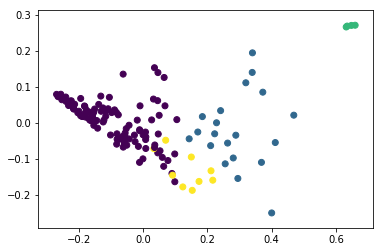

In [28]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

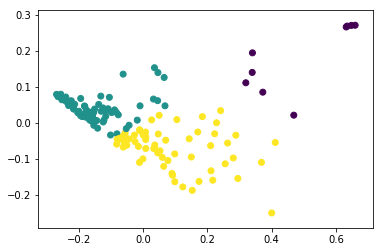

In [29]:
# We know we're looking for three clusters.
n_clusters=3

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_pca)

#Predicted clusters.
predict=sc.fit_predict(X_pca)

#Graph results.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict)
plt.show()

In [30]:
cluster_df3 = poems_df.copy()
cluster_df3['clusters'] = predict

In [31]:
cluster_df3.head()

,poem,poem_titles,authors,word_count,line_count,num_of_sents,processed_poems,max_sent_length,min_sent_length,clusters
52,Having a wheel and four legs of its own Has ne...,TheGrindstone,Frost,601,81,39,"(Having, a, wheel, and, four, legs, of, its, o...",46,5,1
133,A sudden blow: the great wings beating still A...,LedaAndTheSwan,Yeats,113,17,9,"(A, sudden, blow, :, the, great, wings, beatin...",39,2,2
17,To see a World in a Grain of Sand And a Heave...,AuguriesOfInnocence,Blake,839,132,69,"(To, see, a, World, in, a, Grain, of, Sand, ,...",55,2,1
48,"Some say the world will end in fire, Some say ...",FireAndIce,Frost,51,9,4,"(Some, say, the, world, will, end, in, fire, ,...",15,14,1
53,"It was too lonely for her there, And too wild,...",TheHillWife,Frost,135,34,13,"(It, was, too, lonely, for, her, there, ,, And...",26,5,1


In [32]:
cluster3 = cluster_df[cluster_df['cluster']==0]

In [33]:
cluster3 = cluster_df[cluster_df['cluster']==1]

In [34]:
cluster3 = cluster_df[cluster_df['cluster']==2]

### Here is the bag of words analysis starts...

In [35]:
test = []
for i, poem in enumerate(poems_df['processed_poems']):
    poem_sents = [[sent, poems_df.loc[i,'authors']] for sent in poems_df.loc[i,'processed_poems'].sents]
    test.extend(poem_sents)

sentences_df = pd.DataFrame(test)
sentences_df.head()

,0,1
0,"(Lying, ,, thinking, Last, night, How, to, fin...",Angelou
1,"(And, bread, loaf, is, not, stone)",Angelou
2,"(I, came, up, with, one, thing)",Angelou
3,"(And, I, do, n’t, believe, I, ’m, wrong)",Angelou
4,"(That, nobody, ,)",Angelou


### First I will use the bag of words analysis on a poem level. As you can see, the results were not that great with the test sets. With only 140 poems available, I am pretty certain it is because there are not very many samples for the models to work with.

In [36]:
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    return allwords

In [37]:
set_bag = []

for i, poem in enumerate(poems_df['processed_poems']):
    allwords = bag_of_words(poem)
    set_bag.extend(allwords)
set_bag = set(set_bag)

In [38]:
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['processed_poems'] = sentences['processed_poems']
    df['authors'] = sentences['authors']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['processed_poems']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [39]:
bow_df = bow_features(poems_df, set_bag)

Processing row 0


In [40]:
bow_df.shape

(140, 3285)

In [41]:
Y = bow_df['authors']
X = np.array(bow_df.drop(['processed_poems','authors'], 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [42]:
rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('Training set score:', rfc.score(X_train, Y_train))
print('Training set score:', rfc.score(X_test, Y_test))

Training set score: 0.990476190476
Training set score: 0.0571428571429


In [43]:
lr = LogisticRegression()
train = lr.fit(X_train, Y_train)

print('Training set score:', lr.score(X_train, Y_train))
print('Training set score:', lr.score(X_test, Y_test))

Training set score: 1.0
Training set score: 0.0


In [44]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, Y_train)

print('Training set score:', clf.score(X_train, Y_train))
print('Training set score:', clf.score(X_test, Y_test))

Training set score: 1.0
Training set score: 0.0571428571429


In [45]:
svm = SVC(kernel = 'linear')
svm.fit(X_train, Y_train)

print('Training set score:', svm.score(X_train, Y_train))
print('Training set score:', svm.score(X_test, Y_test))

Training set score: 1.0
Training set score: 0.0571428571429


### Below is a bag of words analysis on a sentence level. Now with almost 7,000 samples to use, the test sets performed much better...

In [46]:
def bow_features2(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['processed_poems'] = sentences[0]
    df['authors'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['processed_poems']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [47]:
bow_df2 = bow_features2(sentences_df, set_bag)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500


In [48]:
pd.options.display.max_columns = None
bow_df2.head()

nought extent reasons hide sort sky longing consider sprite females  \
0      0      0       0    0    0   0       0        0      0       0   
1      0      0       0    0    0   0       0        0      0       0   
2      0      0       0    0    0   0       0        0      0       0   
3      0      0       0    0    0   0       0        0      0       0   
4      0      0       0    0    0   0       0        0      0       0   

  treading cabin melt school— session brutishness chip fell weeping  \
0        0     0    0       0       0           0    0    0       0   
1        0     0    0       0       0           0    0    0       0   
2        0     0    0       0       0           0    0    0       0   
3        0     0    0       0       0           0    0    0       0   
4        0     0    0       0       0           0    0    0       0   

  intoxicate prudent beloved spectacle agamemnon shall guest muddy speaking  \
0          0       0       0         0         0     0     0     0        0   
1          0       0       0         0         0     0     0     0        0   
2          0       0       0         0         0     0     0     0        0   
3          0       0       0         0         0     0     0     0        0   
4          0       0       0         0         0     0     0     0        0   

  pride adore pool ow’st somewhat sum farm— herewith weary jump sight home  \
0     0     0    0     0        0   0     0        0     0    0     0    1   
1     0     0    0     0        0   0     0        0     0    0     0    0   
2     0     0    0     0        0   0     0        0     0    0     0    0   
3     0     0    0     0        0   0     0        0     0    0     0    0   
4     0     0    0     0        0   0     0        0     0    0     0    0   

  movin spider jesus despite.’ subtlety trees loin christ order stem meadow  \
0     0      0     0         0        0     0    0      0     0    0      0   
1     0      0     0         0        0     0    0      0     0    0      0   
2     0      0     0         0        0     0    0      0     0    0      0   
3     0      0     0         0        0     0    0      0     0    0      0   
4     0      0     0         0        0     0    0      0     0    0      0   

  that honey rain shop guinea blank nourish'd isle -PRON- dime spire sinew  \
0    0     0    0    0      0     0         0    0      0    0     0     0   
1    0     0    0    0      0     0         0    0      0    0     0     0   
2    0     0    0    0      0     0         0    0      1    0     0     0   
3    0     0    0    0      0     0         0    0      2    0     0     0   
4    1     0    0    0      0     0         0    0      0    0     0     0   

  girl happyheart delicate plead tumble height dim tyger drain bird beanrow  \
0    0          0        0     0      0      0   0     0     0    0       0   
1    0          0        0     0      0      0   0     0     0    0       0   
2    0          0        0     0      0      0   0     0     0    0       0   
3    0          0        0     0      0      0   0     0     0    0       0   
4    0          0        0     0      0      0   0     0     0    0       0   

  flat puberty beam— right fingerlength swirl perceive vice harlot invincible  \
0    0       0     0     0            0     0        0    0      0          0   
1    0       0     0     0            0     0        0    0      0          0   
2    0       0     0     0            0     0        0    0      0          0   
3    0       0     0     0            0     0        0    0      0          0   
4    0       0     0     0            0     0        0    0      0          0   

  basic juice slanders wander nothing franticmad knee lowliness enter  \
0     0     0        0      0       0          0    0         0     0   
1     0     0        0      0       0          0    0         0     0   
2     0     0        0      0       0          0    0         0    

In [49]:
bow_df2 = bow_df2.sample(frac=1)
bow_df2 = bow_df2.sample(frac=1)
bow_df2 = bow_df2.sample(frac=1)
bow_df2 = bow_df2.sample(frac=1)
bow_df2 = bow_df2.sample(frac=1)

In [50]:
bow_df2.shape

(1599, 3285)

In [51]:
Y2 = bow_df2['authors']
X2 = np.array(bow_df2.drop(['processed_poems','authors'], 1))

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.25, random_state=42)

In [52]:
rfc2 = ensemble.RandomForestClassifier()

rfc2.fit(X2_train, Y2_train)

print('Training set score:', rfc2.score(X2_train, Y2_train))
print('Test set score:', rfc2.score(X2_test, Y2_test))

Training set score: 0.979983319433
Test set score: 0.35


In [53]:
cross_val_score(rfc2, X2, Y2, cv=5)

array([ 0.41176471,  0.33333333,  0.29906542,  0.30503145,  0.32278481])

In [54]:
lr2 = LogisticRegression()
lr2.fit(X2_train, Y2_train)

print('Training set score:', lr2.score(X2_train, Y2_train))
print('Training set score:', lr2.score(X2_test, Y2_test))

Training set score: 0.922435362802
Training set score: 0.4625


In [55]:
cross_val_score(lr2,  X2, Y2, cv=5)

array([ 0.46439628,  0.49221184,  0.49844237,  0.45283019,  0.45886076])

In [56]:
svm2 = SVC(kernel = 'linear')
svm2.fit(X2_train, Y2_train)

print('Training set score:', svm2.score(X2_train, Y2_train))
print('Training set score:', svm2.score(X2_test, Y2_test))

Training set score: 0.966638865721
Training set score: 0.4175


In [57]:
cross_val_score(svm2, X2, Y2, cv=5)

array([ 0.41486068,  0.43925234,  0.45794393,  0.39937107,  0.38607595])

### Cluster analysis based off of bag of words...

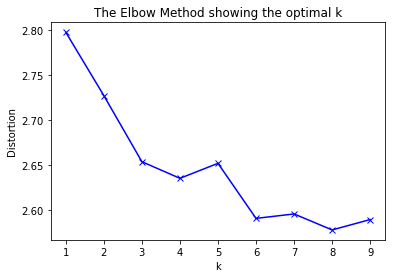

In [58]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X2)
    kmeanModel.fit(X2)
    distortions.append(sum(np.min(cdist(X2, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X2.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [59]:
X2_norm = normalize(X2)

# Calculate predicted values.
Y2_pred = KMeans(n_clusters=7, random_state=42).fit_predict(X2_norm)

In [60]:
bow_clusters_df = bow_df2.copy()

In [61]:
bow_clusters_df['clusters'] = Y2_pred

In [62]:
for i in range(bow_clusters_df['clusters'].nunique()):
    cluster = bow_clusters_df[bow_clusters_df['clusters']== i]
    print('Cluster ', i, '\n', Counter(list(cluster['authors'])),'\n')

Cluster  0 
 Counter({'Hughes': 89, 'Frost': 55, 'Angelou': 52, 'Dickinson': 51, 'Rumi': 33, 'Shakespeare': 32, 'Neruda': 29, 'Yeats': 29, 'Blake': 29, 'LiPo': 9}) 

Cluster  1 
 Counter({'Hughes': 73, 'Frost': 60, 'Neruda': 57, 'Angelou': 54, 'Rumi': 31, 'Shakespeare': 22, 'Yeats': 20, 'Dickinson': 17, 'LiPo': 15, 'Blake': 13}) 

Cluster  2 
 Counter({'Blake': 93, 'Angelou': 60, 'Frost': 32, 'Hughes': 31, 'Yeats': 29, 'Dickinson': 21, 'Rumi': 20, 'Neruda': 18, 'LiPo': 12, 'Shakespeare': 6}) 

Cluster  3 
 Counter({'Angelou': 38, 'Frost': 33, 'Yeats': 26, 'Hughes': 24, 'Neruda': 22, 'Rumi': 18, 'LiPo': 15, 'Blake': 13, 'Dickinson': 9, 'Shakespeare': 2}) 

Cluster  4 
 Counter({'Yeats': 44, 'Angelou': 22, 'Hughes': 22, 'Frost': 10, 'Neruda': 7, 'Dickinson': 7, 'Blake': 6, 'Rumi': 5, 'LiPo': 3, 'Shakespeare': 1}) 

Cluster  5 
 Counter({'Angelou': 3, 'LiPo': 3, 'Blake': 3, 'Hughes': 2, 'Neruda': 2, 'Shakespeare': 1, 'Rumi': 1, 'Dickinson': 1}) 

Cluster  6 
 Counter({'Frost': 34, 'Blake'

In [63]:
bow_cluster0 = bow_clusters_df.loc[bow_clusters_df['clusters']== 0, ['processed_poems','authors']]
for i in bow_cluster0.index:
    print(bow_cluster0.loc[i,'processed_poems'], '\n')

May she be granted beauty and yet not Beauty to make a stranger’s eye distraught, Or hers before a lookingglass, for such, Being made beautiful overmuch, Consider beauty a sufficient end, Lose natural kindness and maybe The heartrevealing intimacy That chooses right, and never find a friend.   

A nickel,       A dime,       A dollar, Two dollars a day.        

O spirit, make thy head in search and seeking like the water of a stream, And O reason, to gain Eternal Life tread everlastingly the way of Death. 

Make the whole stock exchange your own! 

— 

Little Lamb who made thee? 

Knows how to forget! 

“ 

What happens to a dream deferred?         

every atom grew articulate. 

All night, a man called ‘Allah' Until his lips were bleeding. 

But thy eternal summer shall not fade, Nor lose possession of that fair thou ow’st, Nor shall death brag thou wand’rest in his shade, When in eternal lines to Time thou grow’st. 

... 

How sweet and lovely dost thou make the shame Which, like a 


Does my sexiness upset you? 

’s 

Some say the world will end in fire, Some say in ice. 

How to forget 

“ 

Some have relied on what they knew, Others on being simply true. 

Good things for the ones that's got. 

Never show surprise! 

Little Lamb who made thee Dost thou know who made thee Gave thee life & bid thee feed. 

Got the Weary Blues         

Or the plowman in darkness plow?    

Speaks the Unbelievers fright 

O, what a mansion have those vices got Which for their habitation chose out thee, Where beauty's veil doth cover every blot, And all things turn to fair that eyes can see! 

Night and morning with my tears: 

Clean the spittoons, boy.        

Then, in the blazon of sweet beauty’s best, Of hand, of foot, of lip, of eye, of brow 

All the people out of work, Hold for three, then twist and jerk. 

Ah Sunflower! 

Now the moon is being swallowed by the toad and the light flickers out leaving darkness all around; I hear that when nine of the burning suns out of the te

In [64]:
df = bow_clusters_df[bow_clusters_df['clusters']== 0]

In [65]:
bandwidth = estimate_bandwidth(X2, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X2)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 17


In [66]:
bow_mean_shift_clusters = bow_df2.copy()

In [67]:
bow_mean_shift_clusters['clusters'] = labels

In [68]:
for i in range(bow_mean_shift_clusters['clusters'].nunique()):
    cluster = bow_mean_shift_clusters[bow_mean_shift_clusters['clusters']== i]
    print('Cluster ', i, '\n', Counter(list(cluster['authors'])),'\n')

Cluster  0 
 Counter({'Hughes': 255, 'Angelou': 228, 'Frost': 214, 'Blake': 172, 'Yeats': 158, 'Neruda': 134, 'Dickinson': 119, 'Rumi': 116, 'Shakespeare': 69, 'LiPo': 67}) 

Cluster  1 
 Counter({'Hughes': 2}) 

Cluster  2 
 Counter({'Neruda': 1}) 

Cluster  3 
 Counter({'Angelou': 3, 'Yeats': 2, 'Hughes': 1}) 

Cluster  4 
 Counter({'Neruda': 1, 'Shakespeare': 1, 'Rumi': 1, 'Yeats': 1}) 

Cluster  5 
 Counter({'Shakespeare': 1, 'Hughes': 1}) 

Cluster  6 
 Counter({'Hughes': 1}) 

Cluster  7 
 Counter({'Angelou': 1}) 

Cluster  8 
 Counter({'Frost': 4, 'Yeats': 3, 'Blake': 2, 'Hughes': 2, 'Dickinson': 1}) 

Cluster  9 
 Counter({'Blake': 10, 'Angelou': 5, 'Yeats': 4, 'Frost': 4, 'Neruda': 3, 'Rumi': 1, 'Dickinson': 1}) 

Cluster  10 
 Counter({'Hughes': 1}) 

Cluster  11 
 Counter({'Blake': 1}) 

Cluster  12 
 Counter({'Frost': 1}) 

Cluster  13 
 Counter({'Rumi': 1}) 

Cluster  14 
 Counter({'Frost': 1, 'Neruda': 1, 'Yeats': 1, 'LiPo': 1}) 

Cluster  15 
 Counter({'Angelou': 1}) 

C

In [69]:
mean_shift_cluster12 = bow_mean_shift_clusters.loc[bow_mean_shift_clusters['clusters']== 12, ['processed_poems','authors']]

In [70]:
for i in mean_shift_cluster12.index:
    print(mean_shift_cluster12.loc[i,'processed_poems'], '\n')

That lop each other of boughs, but not a few Quite solitary and having equal boughs All round and round. 



In [71]:
mean_shift_cluster14 = bow_mean_shift_clusters.loc[bow_mean_shift_clusters['clusters']== 14, ['processed_poems','authors']]

In [72]:
for i in mean_shift_cluster14.index:
    print(mean_shift_cluster14.loc[i,'processed_poems'], '\n')

It had grown wisetongued by thinking  Of a quiet and light footfall;   But the young queen would not listen;  She rose in her pale nightgown;  She drew in the heavy casement  And pushed the latches down.    

I love you straightforwardly, without complexities or pride; so I love you because I know no other way  than this: where I does not exist, nor you, so close that your hand on my chest is my hand, so close that your eyes close as I fall asleep. 

Amongst the flowers I am alone with my pot of wine drinking by myself; then lifting my cup I asked the moon to drink with me, its reflection and mine in the wine cup, just the three of us; then I sigh for the moon cannot drink, and my shadow goes emptily along with me never saying a word; with no other friends here, I can but use these two for company; in the time of happiness, I too must be happy with all around me; I sit and sing and it is as if the moon accompanies me; then if I dance, it is my shadow that dances along with me; while st

In [73]:
mean_shift_cluster0 = bow_mean_shift_clusters.loc[bow_mean_shift_clusters['clusters']== 0, ['processed_poems','authors']]
for i in mean_shift_cluster0.index:
    print(mean_shift_cluster0.loc[i,'processed_poems'], '\n')

May she be granted beauty and yet not Beauty to make a stranger’s eye distraught, Or hers before a lookingglass, for such, Being made beautiful overmuch, Consider beauty a sufficient end, Lose natural kindness and maybe The heartrevealing intimacy That chooses right, and never find a friend.   

It was at a wine party— I lay in a drowse, knowing it not.   

So I jumped in and sank.   

And I let down the crystal curtain   

O spirit, make thy head in search and seeking like the water of a stream, And O reason, to gain Eternal Life tread everlastingly the way of Death. 

Make the whole stock exchange your own! 

Nor was I for the man so much concerned. 

— 

And thus I say to little English boy.   

Then, it will be true.   

Some are Born to Endless Night   

Little Lamb who made thee? 

Alone, all alone Nobody, but nobody Can make it out here alone.   

It keeps the pressure of a ladderround.   

Make Lame Philosophy to smile  He who Doubts from what he sees   

I doubt if I was tempt

Let the rain beat upon your head with silver liquid drops. 

O, let my land be a land where Liberty Is crowned with no false patriotic wreath, But opportunity is real, and life is free, Equality is in the air we breathe.   

When in the chronicle of wasted time I see descriptions of the fairest wights, And beauty making beautiful old rhyme In praise of ladies dead, and lovely knights, 

When I sing, the moon dances.   

The street filled with tomatoes, midday, summer, light is halved like a tomato, its juice runs through the streets.   

And some one mounted on it rode it hard, 

Of work the men! 

What is the secret? ' 

Like Stone 

But it was there then,   

No likely end could bring them loss     

Rose until it touched the sky—  The wall.   

Men themselves have wondered    What they see in me.   

The truth of the matter 

When I try to show them,    They say they still can’t see.     

Since Adam’s fall but needs much labouring.   

I raise my cup to entice the moon.   

You wil

The woodchuck could say whether it's like his  Long sleep, as I describe its coming on,  Or just some human sleep. 

but I was laying in 

Plant yourself beside the River.   

“I want you to know one thing.   

The scent of apples: I am drowsing off.   

O when may it suffice?   

For His Civility –   We passed the School, where Children strove At Recess – in the Ring –    

Who maketh hard rocks gold by his burning. 

She's glad her simple worsted grey Is silver now with clinging mist.   

You came to my life with what you were bringing, made of light and bread and shadow 

But for livin’ I was born  Though you may hear me holler, 

Being so caught up, So mastered by the brute blood of the air, Did she put on his knowledge with his power Before the indifferent beak 

So sensitive 

Yestereve I delivered to a star tidings for thee: "Present," I said, "my service to that moonlike form. 

We sat together at one summer’s end,  That beautiful mild woman, your close friend,     

Bright pol

As I face them from this villa, drinking my wine.   

And I am dumb. 

Thus did my mother say and kissed me,   

Pumping in my living room.   

Keeps the Human Soul from Care   

Oh, I kept the first for another day!   

: Bring me my arrows of desire: Bring me my Spear: O clouds unfold! 

Sculpt it into The image of your most public self. 

Man wants to be fish or fowl, the snake would like to have wings the dog is a disoriented lion, the engineer would like to be a poet, the fly studies to be a swift, the poet tries to imitate the fly, but the cat only wants to be a cat and any cat is a cat from his whiskers to his tail, from his hopeful vision of a rat to the real thing, from the night to his golden eyes.   

I am the Negro, servant to you all. 

Like a longlegged fly upon the stream Her mind moves upon silence.   

Your footprints by our door, where I had watched you go,  Were hidden, every one of them, under green moss, Hidden under moss too deep to sweep away. 

Transformed utter

To wash the steps with pail and rag Was once the beauty Abishag,  The picture pride of Hollywood. 

But we demand the Flame 

Logarithm Show  “ 

Your longing for Me is My message to you. 

In fetid darkness still to live and run 

The rider, the birds that range     

Fame is the one that does not stay   

For precious friends hid in death 

I'd Be satisfied if he'd be satisfied. 

The gentleness A big cat stalks through stubborn bush 

I want to eat the sunbeam flaring in your lovely body, the sovereign nose of your arrogant face, I want to eat the fleeting shade of your lashes,  and I pace around hungry, sniffing the twilight, hunting for you, for your hot heart, like a puma in the barrens of Quitratue. 

Give birth again To the dream.   

Terror 

So far from caring, I laughed inside, and only cranked the faster, (It ran as if it wasn't greased but glued); I welcomed any moderate disaster That might be calculated to postpone What evidently nothing could conclude.   

I shall be tel


Those sweet excesses that I do adore. 

I’s gwine to quit ma frownin’         

Hold fast to dreams 

On his shoulders     

’T is sweet to know that stocks will stand When we with daisies lie, That commerce will continue, And trades as briskly fly. 

A Lightning in the Germ — 

Frozen with snow. 

The child I works for calls me girl 

Speak Thou, O Soul of Soul of Soul, From desire of whose Face 

O, how I faint when I of you do write, Knowing a better spirit doth use your name, And in the praise thereof spends all his might, To make me tonguetied, speaking of your fame! 

Saying: come out from the grove my love & care, And round my golden tent like lambs rejoice.   

And much said he and I.  `Those breasts are flat and fallen now  Those veins must soon be dry;   

Earth rais'd up her head,  From the darkness dread & drear.   

And I shall have some peace there, for peace comes dropping slow, Dropping from the veils of the morning to where the cricket sings; 

You, created only a lit